In [106]:
import torch
import gpytorch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pygem
import pygem_input as pygem_prms
import pygem.pygem_modelsetup as modelsetup

SyntaxError: unterminated string literal (detected at line 8) (3884977280.py, line 8)

In [107]:
class ExactGPModel(gpytorch.models.ExactGP):
    """ Use the simplest form of GP model, exact inference """
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [108]:
# ===== LOAD GLACIERS =====
glac_no = pygem_prms.glac_no
main_glac_rgi = modelsetup.selectglaciersrgitable(glac_no=glac_no)
glacier_rgi_table = main_glac_rgi.loc[main_glac_rgi.index.values[0], :]
glacier_str = '{0:0.5f}'.format(glacier_rgi_table['RGIId_float'])

em_mod_fn = glacier_str + f'-emulator-bin_thick_monthly.pth'
em_mod_fp = pygem_prms.emulator_fp + 'models/' + glacier_str.split('.')[0].zfill(2) + '/'

# ===== TIME PERIOD =====
dates_table = modelsetup.datesmodelrun(
        startyear=pygem_prms.ref_startyear, endyear=pygem_prms.ref_endyear, spinupyears=pygem_prms.ref_spinupyears,
        option_wateryear=pygem_prms.ref_wateryear)
print(dates_table)

1 glaciers in region 1 are included in this model run: ['22193']
This study is focusing on 1 glaciers in region [1]
               date  year  month  daysinmonth  wateryear  season
timestep                                                        
0        1990-01-01  1990      1           31       1990  winter
1        1990-02-01  1990      2           28       1990  winter
2        1990-03-01  1990      3           31       1990  winter
3        1990-04-01  1990      4           30       1990  winter
4        1990-05-01  1990      5           31       1990  summer
...             ...   ...    ...          ...        ...     ...
379      2021-08-01  2021      8           31       2021  summer
380      2021-09-01  2021      9           30       2021  summer
381      2021-10-01  2021     10           31       2022  winter
382      2021-11-01  2021     11           30       2022  winter
383      2021-12-01  2021     12           31       2022  winter

[384 rows x 6 columns]


In [109]:
# load emulator
torch.set_num_threads(1)

state_dict = torch.load(em_mod_fp + em_mod_fn)

emulator_extra_fn = em_mod_fn.replace('.pth','_extra.pkl')
with open(em_mod_fp + emulator_extra_fn, 'rb') as f:
    emulator_extra_dict = pickle.load(f)

X_train = emulator_extra_dict['X_train']
X_mean = emulator_extra_dict['X_mean']
X_std = emulator_extra_dict['X_std']
y_train = emulator_extra_dict['y_train']
y_mean = emulator_extra_dict['y_mean']
y_std = emulator_extra_dict['y_std']
idx = np.argsort(y_train.numpy())

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Create a new GP model
model = ExactGPModel(X_train, y_train, likelihood)  
# load model state after building emulator from training data
model.load_state_dict(state_dict)
model.eval()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [110]:
lower,upper= likelihood(model(X_train)).confidence_region()
lower = lower.detach().numpy() * y_std + y_mean
upper = upper.detach().numpy() * y_std + y_mean

/Users/btober/miniconda3/envs/pygem-dev/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [111]:
# evaluate model based on the data it was trained upon
y_train_em = model(X_train).mean.detach().numpy() * y_std + y_mean
y_train = y_train * y_std + y_mean

Text(0, 0.5, 'y_em')

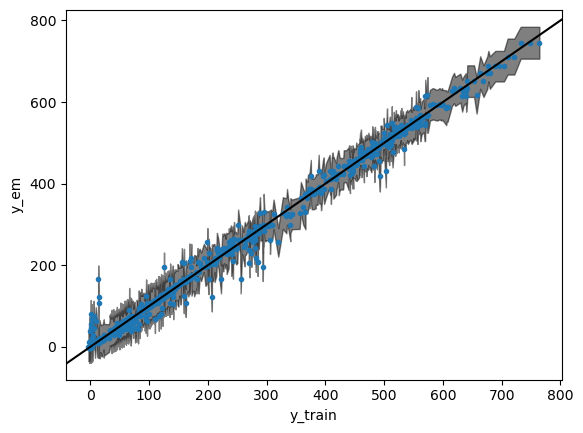

In [115]:
# plot
fig,ax=plt.subplots(1)
ax.fill_between(y_train[idx], lower[idx], upper[idx], color='k', alpha=.5)
ax.plot(y_train[idx], y_train_em[idx],'.')
ax.axline((0, 0), slope=1, c='k')
ax.set_xlabel('y_train')
ax.set_ylabel('y_em')

Text(0.5, 0, 'sample')

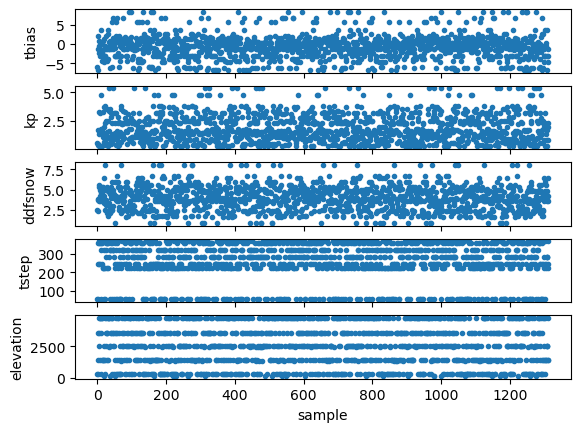

In [116]:
# inspect training x-vals
X = (X_train * X_std + X_mean).to(torch.float).numpy()

fig,ax = plt.subplots(5,sharex=True)
ax[0].plot(X[:,0],'.')
ax[1].plot(X[:,1],'.')
ax[2].plot(X[:,2]*1e3,'.')
ax[3].plot(X[:,3],'.')
ax[4].plot(X[:,4],'.')
ax[0].set_ylabel('tbias')
ax[1].set_ylabel('kp')
ax[2].set_ylabel('ddfsnow')
ax[3].set_ylabel('tstep')
ax[4].set_ylabel('elevation')
ax[4].set_xlabel('sample')

# X_norm = (X - X_mean) / X_std

Now we can see the emulator's performance on the data with which it was trained. Let's test it on other values.

In [117]:
# build function to evaluate the emulator
def run_emulator_bin_thick(model, likelihood, X_eval, X_mean, X_std, y_mean, y_std):
    """ Run the emulator
    """
    try:
        modelprms_norm = (X_eval  - X_mean) / X_std
    except ValueError:
        modelprms_norm = (X_eval.T  - X_mean) / X_std
        
    bin_thick_norm = model(torch.tensor(modelprms_norm).to(torch.float)).mean.detach().numpy()
    bin_thick = bin_thick_norm * y_std + y_mean
    
    lower, upper = likelihood(model(torch.tensor(modelprms_norm).to(torch.float))).confidence_region()
    lower = lower.detach().numpy() * y_std + y_mean
    upper = upper.detach().numpy() * y_std + y_mean

    return bin_thick, lower, upper

In [118]:
modelprms = {}
modelprms['tbias'] = pygem_prms.tbias
modelprms['kp'] = pygem_prms.kp
modelprms['ddfsnow'] = pygem_prms.ddfsnow
modelprms['time'] = 10
modelprms['bin_h'] = 300
modelprms

{'tbias': 5, 'kp': 1, 'ddfsnow': 0.0041, 'time': 10, 'bin_h': 300}

Test run emulator function

In [119]:
X_eval = np.column_stack((modelprms['tbias'], 
                                    modelprms['kp'], 
                                    modelprms['ddfsnow'], 
                                    modelprms['time'], 
                                    modelprms['bin_h']))
out, lower, upper = run_emulator_bin_thick(model, likelihood, X_eval, X_mean, X_std, y_mean, y_std)
print(out, lower, upper)

[206.18817] [-58.065643] [470.44202]


In [120]:
# what about for a range of elevations for a given time step
elev_range = np.arange(200,400,50)
X_eval = np.column_stack((np.repeat(modelprms['tbias'], len(elev_range)), 
                                    np.repeat(modelprms['kp'], len(elev_range)), 
                                    np.repeat(modelprms['ddfsnow'], len(elev_range)), 
                                    np.repeat(modelprms['time'], len(elev_range)), 
                                    elev_range))
out, lower, upper = run_emulator_bin_thick(model, likelihood, X_eval, X_mean, X_std, y_mean, y_std)
print(out)

[204.67325 205.50522 206.18817 206.71466]


In [121]:
# test with training data for sanity check
out_train, lower_train, upper_train = run_emulator_bin_thick(model, likelihood, X, X_mean, X_std, y_mean, y_std)

Text(0, 0.5, 'y_em')

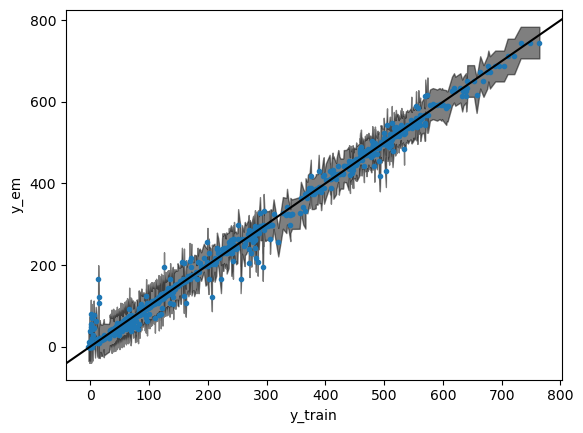

In [122]:
# plot
idx = np.argsort(y_train.numpy())
fig,ax=plt.subplots(1)
ax.fill_between(y_train[idx], lower_train[idx], upper_train[idx], color='k', alpha=.5)
ax.plot(y_train[idx], out_train[idx],'.')
ax.axline((0, 0), slope=1, c='k')
ax.set_xlabel('y_train')
ax.set_ylabel('y_em')

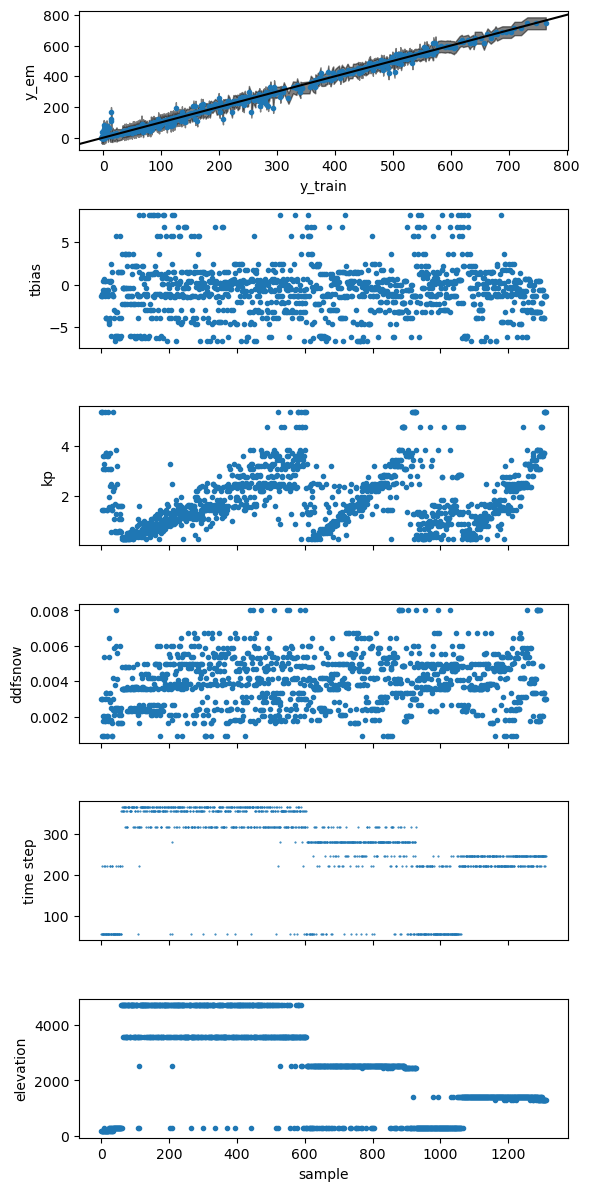

In [123]:
# plot
idx = np.argsort(y_train.numpy())
fig,ax=plt.subplots(6, figsize=(6,12))
ax[0].fill_between(y_train[idx], lower_train[idx], upper_train[idx], color='k', alpha=.5)
ax[0].plot(y_train[idx], out_train[idx],'.')
ax[0].axline((0, 0), slope=1, c='k')
ax[0].set_xlabel('y_train')
ax[0].set_ylabel('y_em')

ax[1].plot(np.arange(len(idx)), X[idx,0], '.')
ax[1].set_ylabel('tbias')

ax[2].plot(np.arange(len(idx)), X[idx,1], '.')
ax[2].set_ylabel('kp')

ax[3].plot(np.arange(len(idx)), X[idx,2], '.')
ax[3].set_ylabel('ddfsnow')

ax[4].plot(np.arange(len(idx)), X[idx,3], '.',ms=1)
ax[4].set_ylabel('time step')

ax[5].plot(np.arange(len(idx)), X[idx,4], '.')
ax[5].set_ylabel('elevation')
ax[5].set_xlabel('sample')

for a in ax[1:-1]:  # Loop through ax[1], ax[2], and ax[3]
    plt.setp(a.get_xticklabels(), visible=False)
fig.tight_layout()

Great, so we can confirm that our run_emulator_bin_thick() method is working as expected - now how does it work for untrained areas/parameters?

In [124]:
# loop through all model time steps for 200-400 m and evaluate model
elev_range = np.arange(0,4500,100)
time_steps = dates_table.index.values[::12]

In [125]:
bin_thick = []
lower = []
upper = []
for t in time_steps:
    print(t)
    X_eval = np.column_stack((np.repeat(modelprms['tbias'],len(elev_range)), 
                                    np.repeat(modelprms['kp'],len(elev_range)), 
                                    np.repeat(modelprms['ddfsnow'],len(elev_range)), 
                                    np.repeat(t,len(elev_range)), 
                                    elev_range))

    
    out, l, u  = run_emulator_bin_thick(model, likelihood, X_eval, X_mean, X_std, y_mean, y_std)
    bin_thick.append(out)
    lower.append(l)
    upper.append(u)

0
12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288
300
312
324
336
348
360
372


/var/folders/c2/td_159j56jb0xt8x35wytcw40000gn/T/ipykernel_89230/855628658.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(time_steps))


Text(0, 0.5, 'Thickness (m)')

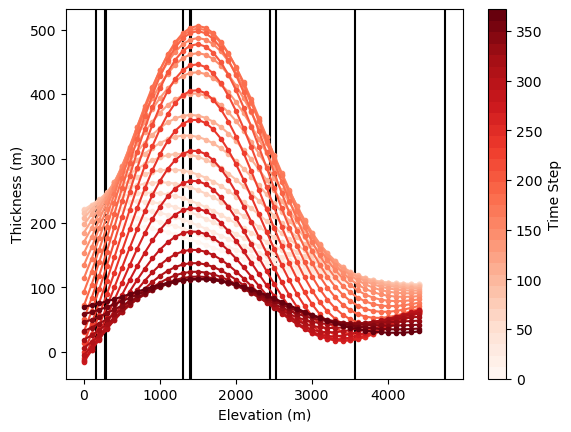

In [126]:
pad = '1%'
size = '3%'
fig,ax = plt.subplots(1)
# Create a colormap instance
cmap = plt.cm.get_cmap('Reds', len(time_steps))
# Normalize indices to [0, 1] for colormap
norm = plt.Normalize(time_steps.min(), time_steps.max())

for t in range(len(time_steps)):
    ax.plot(elev_range, bin_thick[t], marker='.', ms=6, color=cmap(norm(time_steps[t])))
#     ax.fill_between(elev_range, lower[t], upper[t], color=cmap(norm(time_steps[t])))

for e in np.unique(X[:,4]):
    ax.axvline(x=e,c='k',zorder=0)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Time Step')
ax.set_xlabel('Elevation (m)')
ax.set_ylabel('Thickness (m)')

/var/folders/c2/td_159j56jb0xt8x35wytcw40000gn/T/ipykernel_89230/1002865147.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', len(time_steps))
/var/folders/c2/td_159j56jb0xt8x35wytcw40000gn/T/ipykernel_89230/1002865147.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1)


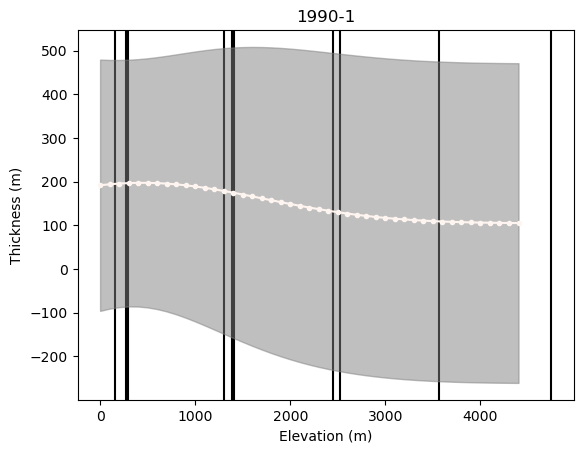

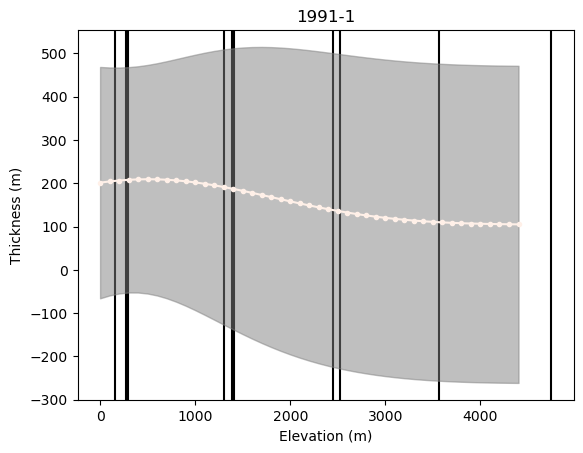

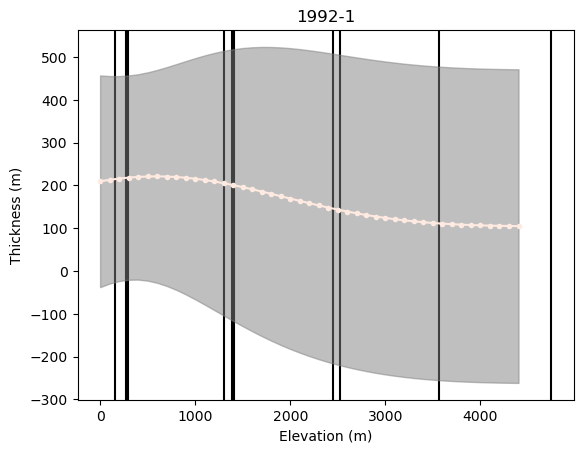

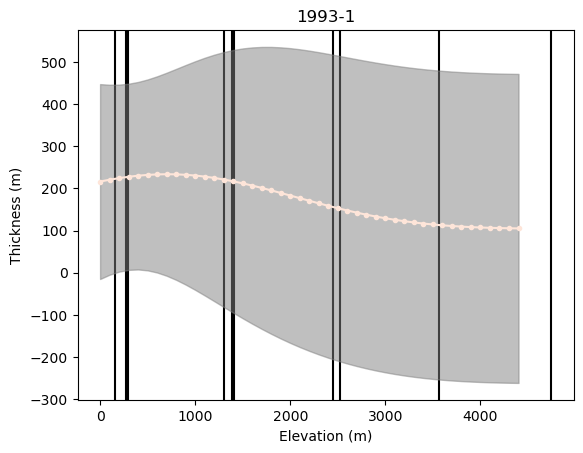

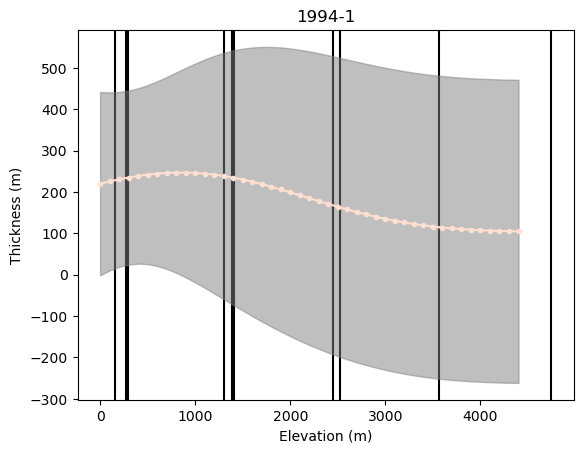

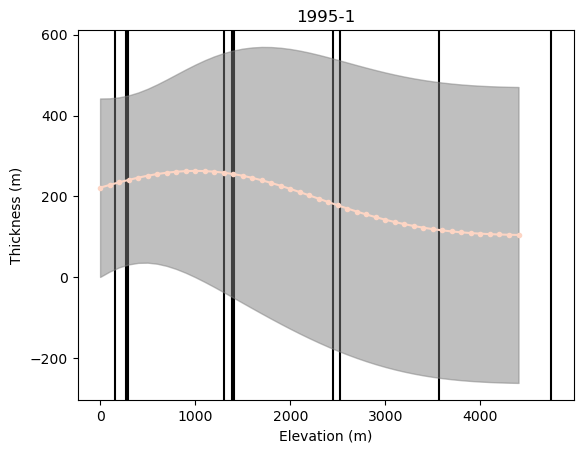

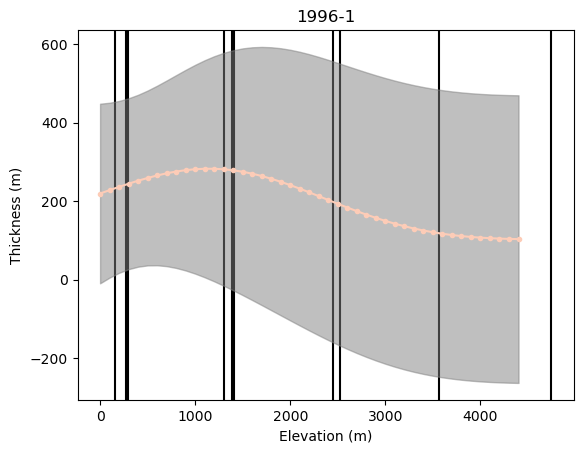

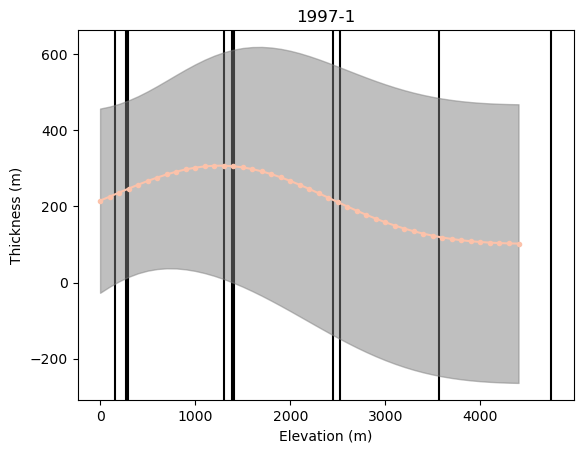

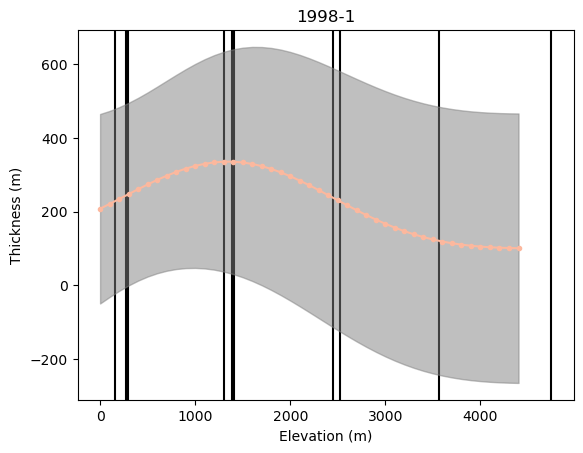

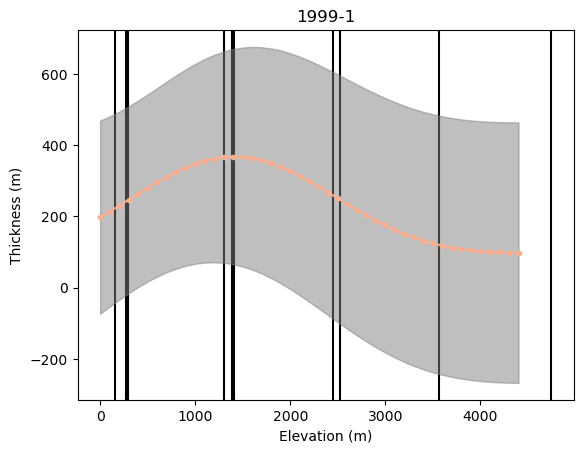

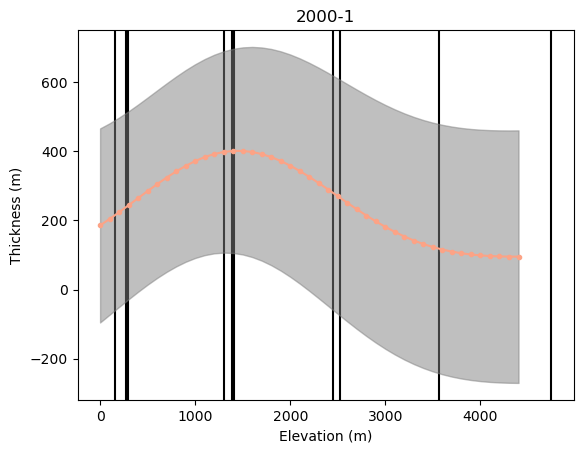

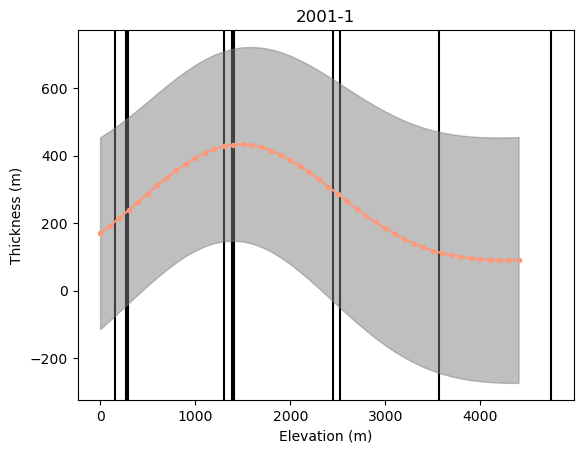

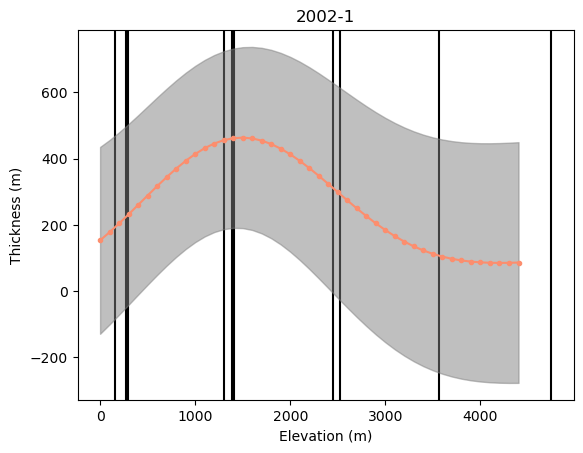

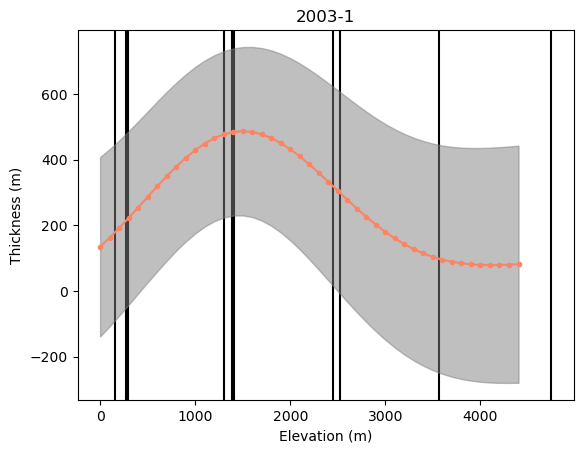

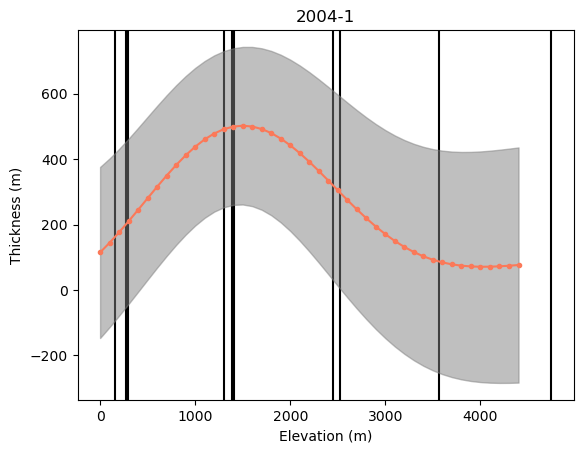

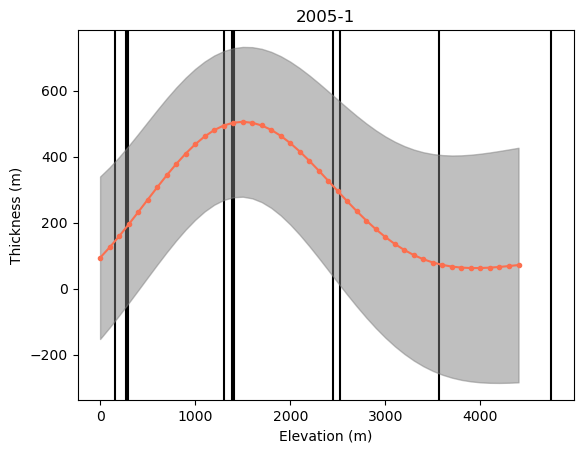

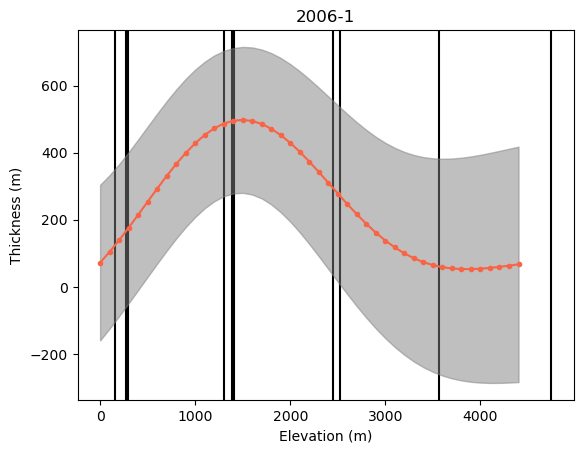

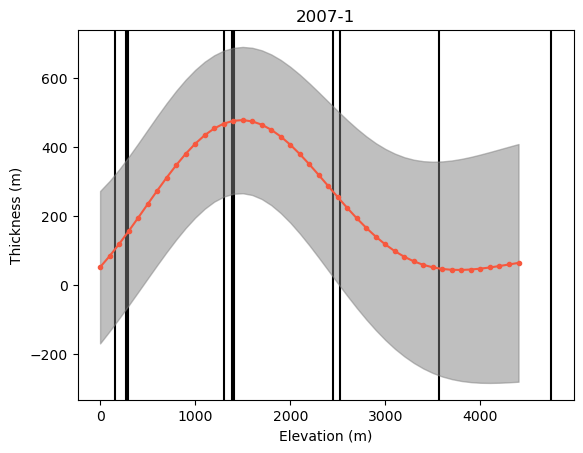

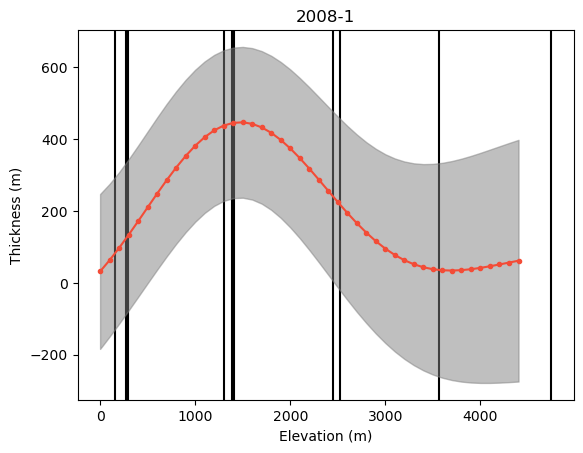

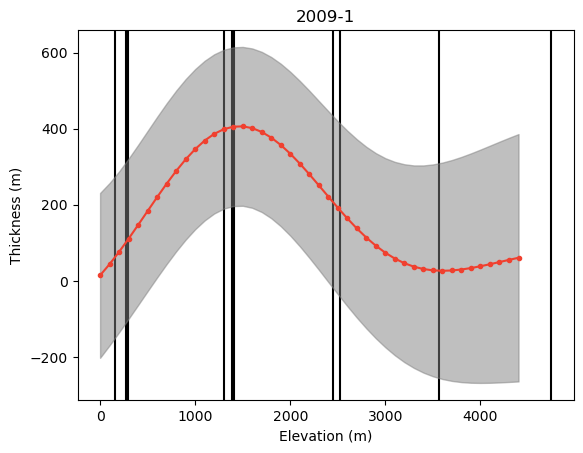

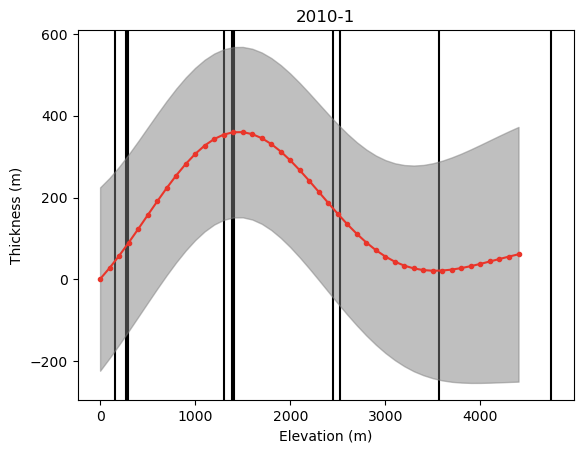

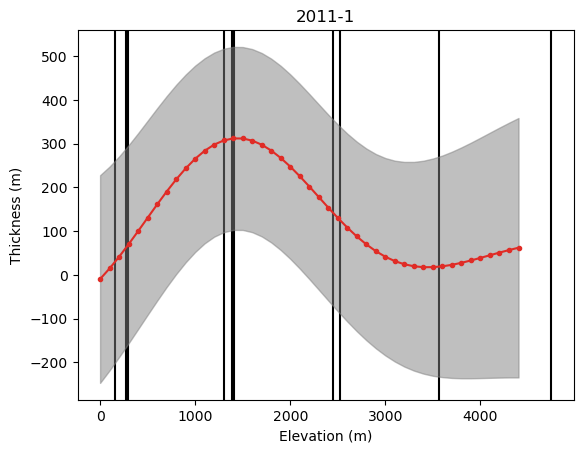

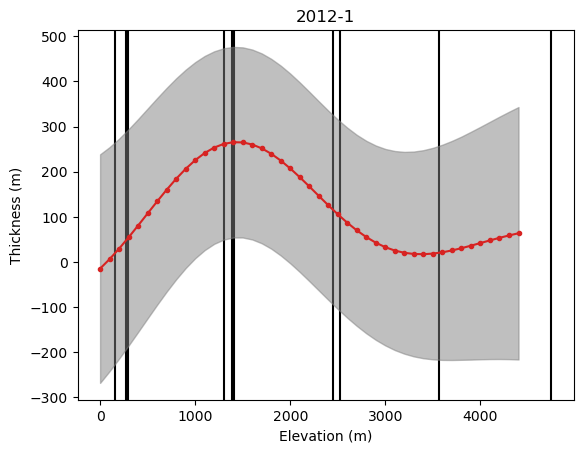

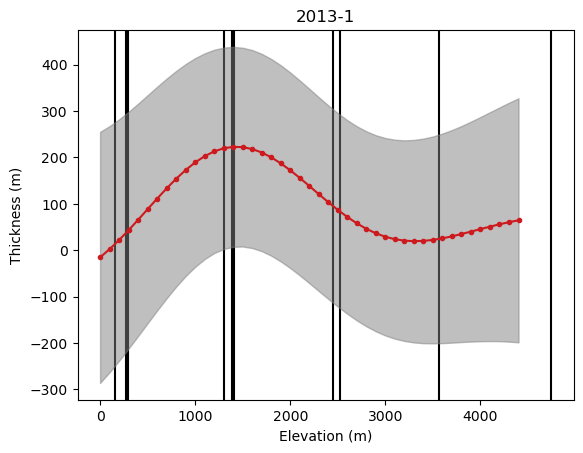

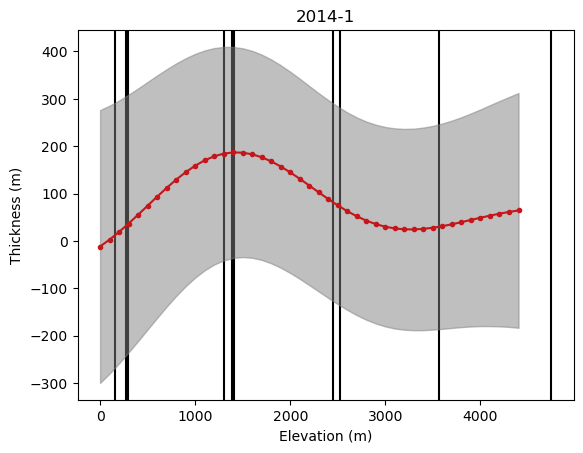

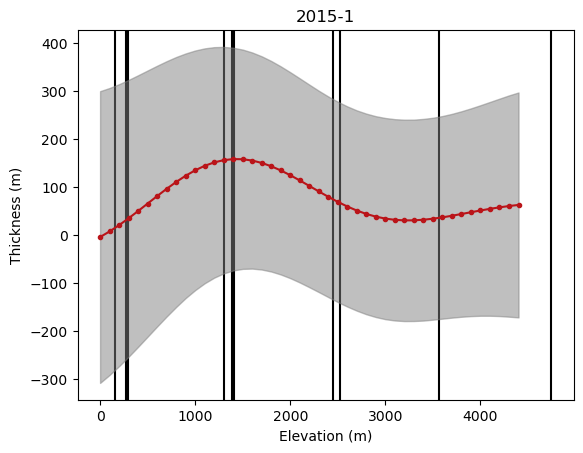

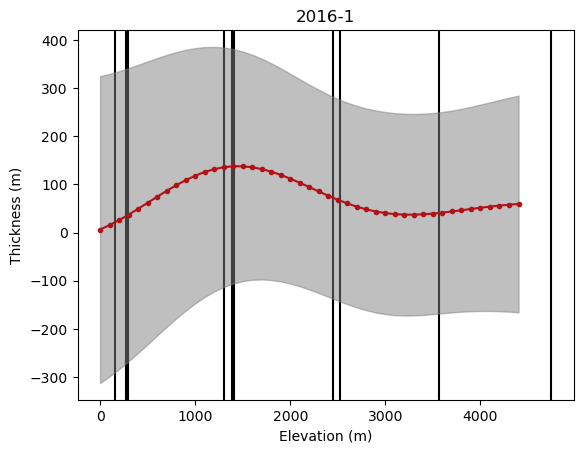

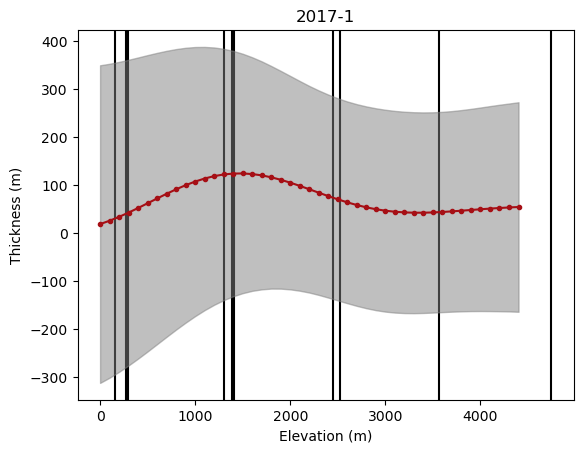

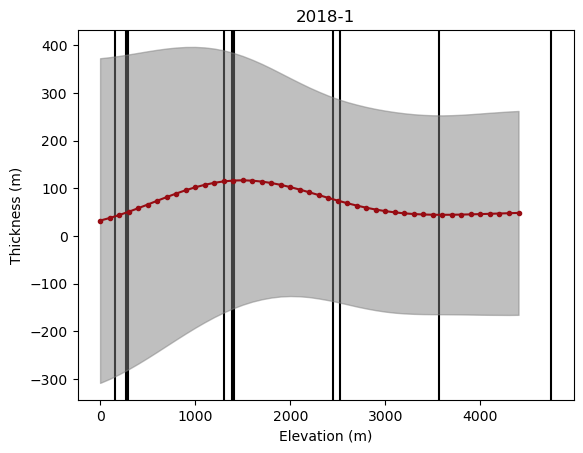

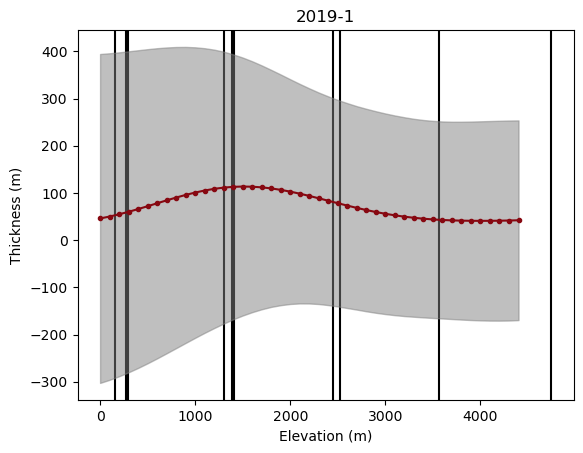

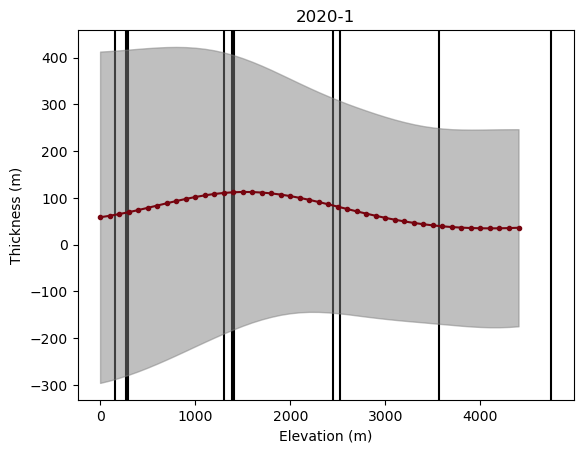

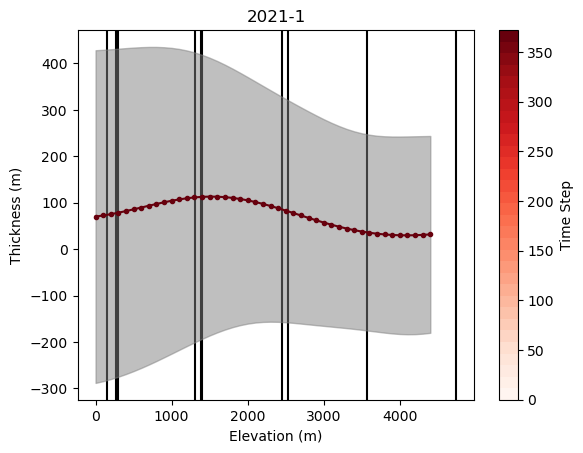

In [127]:
pad = '1%'
size = '3%'
# Create a colormap instance
cmap = plt.cm.get_cmap('Reds', len(time_steps))
# Normalize indices to [0, 1] for colormap
norm = plt.Normalize(time_steps.min(), time_steps.max())

for t in range(len(time_steps)):
    fig,ax = plt.subplots(1)
    ax.plot(elev_range, bin_thick[t], marker='.', ms=6, color=cmap(norm(time_steps[t])))
    ax.fill_between(elev_range, lower[t], upper[t], color='gray', alpha=.5)

    for e in np.unique(X[:,4]):
        ax.axvline(x=e,c='k',zorder=0)
    ax.set_xlabel('Elevation (m)')
    ax.set_ylabel('Thickness (m)')
    ax.set_title([str(x.year)+ '-' + str(x.month) for x in [dates_table.iloc[t*12]['date']]][0])
    
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label('Time Step')

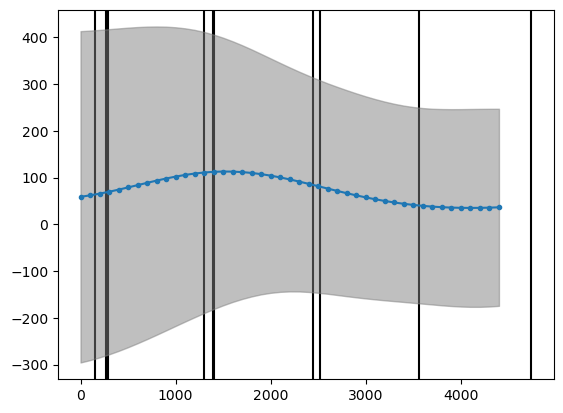

In [128]:
fig,ax = plt.subplots(1)

ax.plot(elev_range, bin_thick[30], marker='.', ms=6)
ax.fill_between(elev_range, lower[30], upper[30],color='gray',alpha=.5)

for e in np.unique(X[:,4]):
    ax.axvline(x=e,c='k',zorder=0)

In [86]:
np.unique(X[:,3])

array([ 55.00001, 221.     , 245.     , 281.     , 317.     , 357.     ,
       365.     ], dtype=float32)

In [102]:
tmp_idxs = np.where(X[:,3]==245)[0]

In [103]:
tmp_idxs

array([   3,    4,    9,   15,   52,   56,   64,   69,   77,   82,   84,
         92,  110,  112,  117,  138,  154,  155,  161,  163,  167,  169,
        171,  173,  174,  177,  180,  188,  201,  209,  213,  217,  237,
        240,  244,  269,  271,  274,  282,  294,  296,  304,  317,  318,
        326,  341,  342,  344,  345,  350,  359,  365,  374,  387,  405,
        406,  412,  413,  415,  426,  428,  432,  433,  449,  457,  461,
        479,  481,  498,  501,  503,  510,  530,  532,  541,  544,  556,
        559,  566,  585,  593,  595,  607,  618,  620,  627,  632,  644,
        660,  665,  671,  673,  674,  677,  679,  680,  681,  683,  693,
        704,  722,  726,  729,  740,  750,  752,  769,  781,  794,  796,
        809,  821,  857,  863,  864,  868,  871,  889,  890,  894,  908,
        914,  917,  918,  940,  948,  950,  966,  971,  977,  978,  986,
        989,  991,  992, 1007, 1014, 1017, 1018, 1036, 1042, 1044, 1050,
       1051, 1070, 1078, 1088, 1091, 1102, 1108, 11

In [104]:
Xs_tmp = X[tmp_idxs,:]

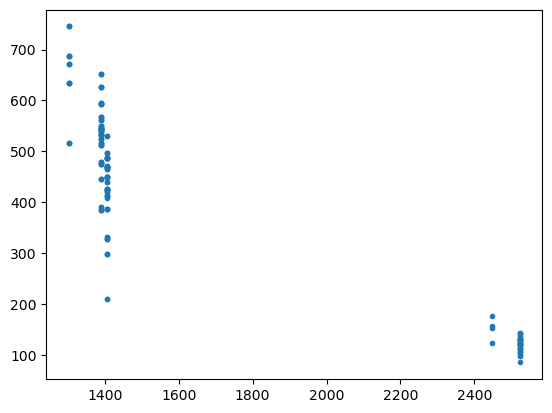

In [105]:
plt.plot(X[tmp_idxs,-1],out_train[tmp_idxs],'.')